# 【AI达人创造营第二期】基于PaddleSeg的遥感影像道路提取

# 一、项目背景介绍

遥感影像道路提取, 即从遥感影像中提取道路。在路线导航、道路规划等领域中具有很高的实用价值。然而道路在影像中占比面积不如一些地块建筑，识别难度高。在乡镇农村中，由于路径开设的随意性，道路往往较为复杂，识别难度更上一层。因此在实际应用中，仍然大量依赖于人工处理，需要消耗大量的人力、物力、财力。本项目旨在利用人工智能技术，对遥感影像数据进行充分挖掘，从遥感影像中提取道路。

# 二、数据介绍

本项目数据采用DeepGlobe 道路提取数据集，来源于 DeepGlobe 2018：通过卫星图像解析地球的挑战。Road Challenge 的训练数据包含 6226 张 RGB 卫星图像，大小为 1024x1024。该图像具有 50 厘米像素分辨率，由 DigitalGlobe 的卫星收集。本项目只采用了其中1000个样本。


## 2.1 数据预览

In [3]:
#查看数据集的目录结构
! tree -d /home/aistudio/dataset/roadunzipp -d 

/home/aistudio/dataset/roadunzipp
└── road
    ├── image
    │   ├── test
    │   ├── train
    │   └── val
    └── label
        ├── test
        ├── train
        └── val

9 directories


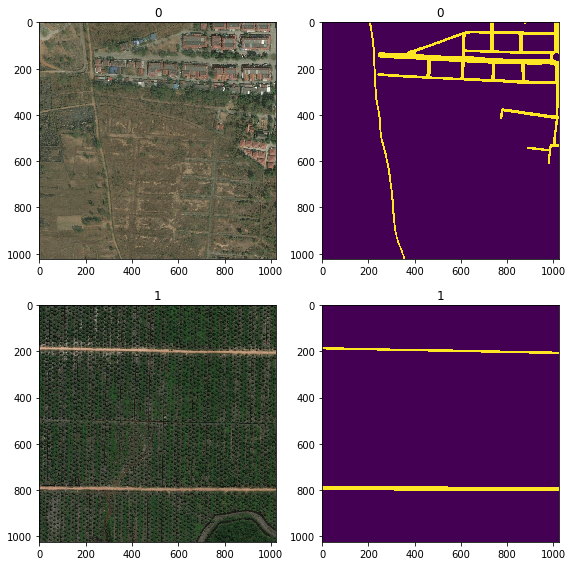

In [5]:
# 样本可视化
import cv2
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False #显示负号
%matplotlib inline

image_path_list = ['dataset/roadunzipp/road/image/train/100892_sat.jpg', 'dataset/roadunzipp/road/image/train/100081_sat.jpg']
label_path_list = [path.replace('image', 'label').replace('sat', 'mask').replace('jpg', 'png')
                   for path in image_path_list]

plt.figure(figsize=(8, 8))
for i in range(len(image_path_list)):
    plt.subplot(len(image_path_list), 2, i*2+1)
    plt.title(i) 
    plt.imshow(cv2.imread(image_path_list[i])[:, :, ::-1])

    plt.subplot(len(image_path_list), 2, i*2+2)
    plt.title(i)
    plt.imshow(cv2.imread(label_path_list[i], cv2.IMREAD_GRAYSCALE))
plt.tight_layout()
plt.show()

## 2.2 图像预处理

由于遮罩图像的值可能不是纯0和255，转换为标签时，需要在阈值128处进行二值化。

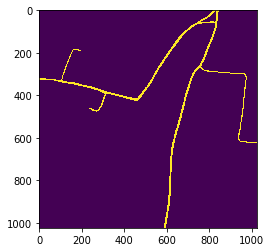

In [6]:
import cv2
import matplotlib.pyplot as plt
import glob
import pdb


def grayImg(pnglist,savedir):
    for x in pnglist:
        #读取图片
        labelname=str(x).split('/')[-1]
        img = cv2.imread(x)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        difference = 128
        retval, img_binary = cv2.threshold(img_gray, difference, 1, cv2.THRESH_BINARY)
        # print("阈值：", _)
        #保存灰度后的新图片
        cv2.imwrite(savedir.format(labelname), img_binary)
    plt.imshow(img_binary)
    plt.show()
trainlist=glob.glob(r"dataset/roadunzipp/road/label/train/*.png")
traindir="dataset/roadunzipp/road/label/train01/{}"
grayImg(trainlist,traindir)

## 2.3 图像的统计分析

In [9]:
# 计算图像数据整体均值和方差
import glob
import numpy as np


def get_mean_std(image_path_list):
    print('Total images:', len(image_path_list))
    max_val, min_val = np.zeros(3), np.ones(3) * 255
    mean, std = np.zeros(3), np.zeros(3)
    for image_path in image_path_list:
        image = cv2.imread(image_path)
        for c in range(3):
            mean[c] += image[:, :, c].mean()
            std[c] += image[:, :, c].std()
            max_val[c] = max(max_val[c], image[:, :, c].max())
            min_val[c] = min(min_val[c], image[:, :, c].min())

    mean /= len(image_path_list) #均值
    std /= len(image_path_list)  #标准差

    mean /= max_val - min_val
    std /= max_val - min_val

    return mean, std
mean, std = get_mean_std(glob.glob('dataset/roadunzipp/road/image/train/*.jpg'))
print('mean:', mean)
print('std:', std)

Total images: 800
mean: [0.29332166 0.3878038  0.41410305]
std: [0.09742112 0.10564412 0.12984675]


## 2.4 数据集类的定义

In [10]:
import paddle
import numpy as np
import paddle.vision.transforms as T
import pdb


class MyImageNetDataset(paddle.io.Dataset):
    def __init__(self,
                 num_samples,
                 num_classes):
        super(MyImageNetDataset, self).__init__()

        self.num_samples = num_samples #sample数量
        self.num_classes = num_classes # 分类数量
        self.transform = T.Compose([
            T.Resize(size=(224, 224)),
            T.ToTensor(),
            T.Normalize(mean=127.5, std=127.5)])

    def __getitem__(self, index):
        image = np.random.randint(low=0, high=256, size=(512, 512, 3))
        label = np.random.randint(low=0, high=self.num_classes, size=(1,))

        image = image.astype('float32')
        label = label.astype('int64')

        image = self.transform(image)

        return image, label

    def __len__(self):
        return self.num_samples

## 2.5 数据集类的测试

In [11]:
train_dataset = MyImageNetDataset(num_samples=800, num_classes=2) #建立对象
print(len(train_dataset)) #get length
image, label = train_dataset[0] 
print(image.shape, label.shape) #image图像的大小,label图像的大小

for image, label in train_dataset:
    print(image.shape, label.shape)
    break
  
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=200,
    shuffle=True,
    drop_last=False)

for step, data in enumerate(train_dataloader):
    image, label = data
    print(step, image.shape, label.shape)

800
[3, 224, 224] (1,)
[3, 224, 224] (1,)
0 [200, 3, 224, 224] [200, 1]
1 [200, 3, 224, 224] [200, 1]
2 [200, 3, 224, 224] [200, 1]
3 [200, 3, 224, 224] [200, 1]


## 2.6 生成图像列表

In [12]:
#篇幅有限只展现trian_list
import os
path_origin = 'dataset/roadunzipp/road/image/train/'
path_seg = 'dataset/roadunzipp/road/label/train/'
pic_dir = os.listdir(path_origin)
ltrain=len(pic_dir)
f_train = open('train_list.txt', 'w')
for i in range(ltrain):
    f_train.write(path_origin + pic_dir[i] + ' ' + path_seg + pic_dir[i].split('.')[0].replace('sat','mask') + '.png' + '\n')
f_train.close()

# 三. 模型介绍

本项目选择BiseNetV2模型，BiseNetV2是一个轻量化模型，在Cityscapes测试集中的平均IoU达到72.6％，在一张NVIDIA GeForce GTX 1080 Ti卡上的速度为156 FPS，这比现有方法要快得多，而且可以实现更好的分割精度。

## 3.1 BiseNetV2模型介绍

双边分割网络(BiSeNet V2)，将低层次的网络细节和高层次的语义分类分开处理，以实现高精度和高效率的实时语义分割。它在速度和精度之间进行权衡。该体系结构包括：

(1)一个细节分支，具有浅层宽通道，用于捕获低层细节并生成高分辨率的特征表示。

(2)一个语义分支，通道窄，层次深，获取高层次语义语境。语义分支是轻量级的，因为它减少了通道容量和快速下采样策略。此外，设计了一个引导聚合层来增强相互连接和融合这两种类型的特征表示。此外，还设计了一种增强型训练策略，在不增加任何推理代价的情况下提高分割性能。  
  
    
    
![](https://ai-studio-static-online.cdn.bcebos.com/7aadcf87bfd745d6a25921fb13177d7217ec2cff91b643a7a62e176b4e70bc7f)

# 四. 模型训练

## 4.1 环境配置

In [16]:
! pip install paddleseg

In [17]:
! git clone https://gitee.com/paddlepaddle/PaddleSeg.git PaddleSeg

## 4.2 参数配置

In [ ]:
batch_size: 4  #设定batch_size的值即为迭代一次送入网络的图片数量，一般显卡显存越大，batch_size的值可以越大
iters: 1000    #模型迭代的次数

train_dataset:
  type: Dataset
  dataset_root: dataset/roadunzipp/road
  train_path: train_list.txt
  num_classes: 2
  transforms:
    - type: Resize
      target_size: [512, 512]
    - type: RandomHorizontalFlip
    - type: Normalize
  mode: train

val_dataset:
  type: Dataset
  dataset_root: dataset/roadunzipp/road
  val_path: val_list.txt
  num_classes: 2
  transforms:
    - type: Resize  
      target_size: [512, 512]  
    - type: Normalize
  mode: val

optimizer: #设定优化器的类型
  type: sgd #采用SGD（Stochastic Gradient Descent）随机梯度下降方法为优化器
  momentum: 0.9 #动量
  weight_decay: 4.0e-5 #权值衰减，使用的目的是防止过拟合

learning_rate: #设定学习率
  value: 0.01  #初始学习率
  decay:
    type: poly  #采用poly作为学习率衰减方式。
    power: 0.9  #衰减率
    end_lr: 0   #最终学习率

loss: #设定损失函数的类型
  types:
    - type: CrossEntropyLoss #损失函数类型
  coef: [1, 1, 1, 1, 1]
  #BiseNetV2有4个辅助loss，加上主loss共五个，1表示权重 all_loss = coef_1 * loss_1 + .... + coef_n * loss_n

model: #模型说明
  type: BiSeNetV2  #设定模型类别
  pretrained: Null #设定模型的预训练模型

## 4.3 开始训练

In [ ]:
!python PaddleSeg/train.py \
       --config PaddleSeg/configs/quick_start/bisenet_optic_disc_512x512_1k.yml \
       --do_eval \
       --use_vdl \
       --save_interval 500 \
       --save_dir output

In [ ]:
#由于训练时间过长，之前的作业里面已经做过训练，这里展示输出如下：
2022-02-27 20:45:59 [INFO]	[TRAIN] epoch: 1, iter: 10/1000, loss: 2.0377, lr: 0.009919, batch_cost: 0.1301, reader_cost: 0.02306, ips: 30.7529 samples/sec | ETA 00:02:08
2022-02-27 20:46:00 [INFO]	[TRAIN] epoch: 1, iter: 20/1000, loss: 0.5713, lr: 0.009829, batch_cost: 0.1101, reader_cost: 0.00017, ips: 36.3316 samples/sec | ETA 00:01:47
2022-02-27 20:46:01 [INFO]	[TRAIN] epoch: 1, iter: 30/1000, loss: 0.3956, lr: 0.009739, batch_cost: 0.0822, reader_cost: 0.00230, ips: 48.6674 samples/sec | ETA 00:01:19
2022-02-27 20:46:02 [INFO]	[TRAIN] epoch: 1, iter: 40/1000, loss: 0.3171, lr: 0.009648, batch_cost: 0.0856, reader_cost: 0.00715, ips: 46.7061 samples/sec | ETA 00:01:22
2022-02-27 20:46:03 [INFO]	[TRAIN] epoch: 1, iter: 50/1000, loss: 0.2890, lr: 0.009558, batch_cost: 0.0862, reader_cost: 0.00908, ips: 46.4241 samples/sec | ETA 00:01:21
2022-02-27 20:46:04 [INFO]	[TRAIN] epoch: 1, iter: 60/1000, loss: 0.2773, lr: 0.009467, batch_cost: 0.0876, reader_cost: 0.00265, ips: 45.6741 samples/sec | ETA 00:01:22
2022-02-27 20:46:05 [INFO]	[TRAIN] epoch: 2, iter: 70/1000, loss: 0.2297, lr: 0.009377, batch_cost: 0.0896, reader_cost: 0.00857, ips: 44.6240 samples/sec | ETA 00:01:23
2022-02-27 20:46:05 [INFO]	[TRAIN] epoch: 2, iter: 80/1000, loss: 0.2488, lr: 0.009286, batch_cost: 0.0916, reader_cost: 0.01306, ips: 43.6883 samples/sec | ETA 00:01:24
2022-02-27 20:46:06 [INFO]	[TRAIN] epoch: 2, iter: 90/1000, loss: 0.2166, lr: 0.009195, batch_cost: 0.0889, reader_cost: 0.00754, ips: 44.9764 samples/sec | ETA 00:01:20
2022-02-27 20:46:07 [INFO]	[TRAIN] epoch: 2, iter: 100/1000, loss: 0.2176, lr: 0.009104, batch_cost: 0.0855, reader_cost: 0.00860, ips: 46.7660 samples/sec | ETA 00:01:16
2022-02-27 20:46:08 [INFO]	[TRAIN] epoch: 2, iter: 110/1000, loss: 0.2577, lr: 0.009013, batch_cost: 0.0869, reader_cost: 0.00782, ips: 46.0460 samples/sec | ETA 00:01:17
2022-02-27 20:46:09 [INFO]	[TRAIN] epoch: 2, iter: 120/1000, loss: 0.2231, lr: 0.008922, batch_cost: 0.0873, reader_cost: 0.00803, ips: 45.8235 samples/sec | ETA 00:01:16
2022-02-27 20:46:10 [INFO]	[TRAIN] epoch: 2, iter: 130/1000, loss: 0.2074, lr: 0.008831, batch_cost: 0.0875, reader_cost: 0.01061, ips: 45.7347 samples/sec | ETA 00:01:16
2022-02-27 20:46:11 [INFO]	[TRAIN] epoch: 3, iter: 140/1000, loss: 0.2062, lr: 0.008740, batch_cost: 0.0957, reader_cost: 0.01600, ips: 41.7788 samples/sec | ETA 00:01:22
2022-02-27 20:46:12 [INFO]	[TRAIN] epoch: 3, iter: 150/1000, loss: 0.1730, lr: 0.008648, batch_cost: 0.0932, reader_cost: 0.01301, ips: 42.9058 samples/sec | ETA 00:01:19
2022-02-27 20:46:13 [INFO]	[TRAIN] epoch: 3, iter: 160/1000, loss: 0.2104, lr: 0.008557, batch_cost: 0.1176, reader_cost: 0.00105, ips: 34.0029 samples/sec | ETA 00:01:38
2022-02-27 20:46:14 [INFO]	[TRAIN] epoch: 3, iter: 170/1000, loss: 0.1695, lr: 0.008465, batch_cost: 0.0928, reader_cost: 0.00056, ips: 43.1155 samples/sec | ETA 00:01:17
2022-02-27 20:46:15 [INFO]	[TRAIN] epoch: 3, iter: 180/1000, loss: 0.2109, lr: 0.008374, batch_cost: 0.0851, reader_cost: 0.00160, ips: 46.9849 samples/sec | ETA 00:01:09
2022-02-27 20:46:15 [INFO]	[TRAIN] epoch: 3, iter: 190/1000, loss: 0.1676, lr: 0.008282, batch_cost: 0.0812, reader_cost: 0.00015, ips: 49.2450 samples/sec | ETA 00:01:05
2022-02-27 20:46:16 [INFO]	[TRAIN] epoch: 4, iter: 200/1000, loss: 0.1831, lr: 0.008190, batch_cost: 0.0862, reader_cost: 0.00952, ips: 46.4138 samples/sec | ETA 00:01:08
2022-02-27 20:46:17 [INFO]	[TRAIN] epoch: 4, iter: 210/1000, loss: 0.1501, lr: 0.008098, batch_cost: 0.0859, reader_cost: 0.00812, ips: 46.5871 samples/sec | ETA 00:01:07
2022-02-27 20:46:18 [INFO]	[TRAIN] epoch: 4, iter: 220/1000, loss: 0.1828, lr: 0.008005, batch_cost: 0.0847, reader_cost: 0.00259, ips: 47.2091 samples/sec | ETA 00:01:06
2022-02-27 20:46:19 [INFO]	[TRAIN] epoch: 4, iter: 230/1000, loss: 0.1819, lr: 0.007913, batch_cost: 0.0850, reader_cost: 0.00700, ips: 47.0755 samples/sec | ETA 00:01:05
2022-02-27 20:46:20 [INFO]	[TRAIN] epoch: 4, iter: 240/1000, loss: 0.1448, lr: 0.007821, batch_cost: 0.0839, reader_cost: 0.00222, ips: 47.6502 samples/sec | ETA 00:01:03
2022-02-27 20:46:21 [INFO]	[TRAIN] epoch: 4, iter: 250/1000, loss: 0.1791, lr: 0.007728, batch_cost: 0.0834, reader_cost: 0.00235, ips: 47.9857 samples/sec | ETA 00:01:02
2022-02-27 20:46:21 [INFO]	[TRAIN] epoch: 4, iter: 260/1000, loss: 0.1530, lr: 0.007635, batch_cost: 0.0837, reader_cost: 0.00556, ips: 47.8003 samples/sec | ETA 00:01:01
2022-02-27 20:46:22 [INFO]	[TRAIN] epoch: 5, iter: 270/1000, loss: 0.1657, lr: 0.007543, batch_cost: 0.0917, reader_cost: 0.01527, ips: 43.6117 samples/sec | ETA 00:01:06
2022-02-27 20:46:23 [INFO]	[TRAIN] epoch: 5, iter: 280/1000, loss: 0.1599, lr: 0.007450, batch_cost: 0.0823, reader_cost: 0.00574, ips: 48.5882 samples/sec | ETA 00:00:59
2022-02-27 20:46:24 [INFO]	[TRAIN] epoch: 5, iter: 290/1000, loss: 0.1838, lr: 0.007357, batch_cost: 0.0875, reader_cost: 0.01037, ips: 45.7104 samples/sec | ETA 00:01:02
2022-02-27 20:46:25 [INFO]	[TRAIN] epoch: 5, iter: 300/1000, loss: 0.1398, lr: 0.007264, batch_cost: 0.1181, reader_cost: 0.01539, ips: 33.8604 samples/sec | ETA 00:01:22
2022-02-27 20:46:26 [INFO]	[TRAIN] epoch: 5, iter: 310/1000, loss: 0.1382, lr: 0.007170, batch_cost: 0.1207, reader_cost: 0.00474, ips: 33.1316 samples/sec | ETA 00:01:23
2022-02-27 20:46:28 [INFO]	[TRAIN] epoch: 5, iter: 320/1000, loss: 0.1616, lr: 0.007077, batch_cost: 0.1110, reader_cost: 0.00366, ips: 36.0483 samples/sec | ETA 00:01:15
2022-02-27 20:46:29 [INFO]	[TRAIN] epoch: 5, iter: 330/1000, loss: 0.1537, lr: 0.006983, batch_cost: 0.1124, reader_cost: 0.00539, ips: 35.5894 samples/sec | ETA 00:01:15
2022-02-27 20:46:30 [INFO]	[TRAIN] epoch: 6, iter: 340/1000, loss: 0.1441, lr: 0.006889, batch_cost: 0.0890, reader_cost: 0.01140, ips: 44.9558 samples/sec | ETA 00:00:58
2022-02-27 20:46:30 [INFO]	[TRAIN] epoch: 6, iter: 350/1000, loss: 0.1342, lr: 0.006796, batch_cost: 0.0877, reader_cost: 0.00711, ips: 45.6091 samples/sec | ETA 00:00:57
2022-02-27 20:46:31 [INFO]	[TRAIN] epoch: 6, iter: 360/1000, loss: 0.1476, lr: 0.006702, batch_cost: 0.0843, reader_cost: 0.00811, ips: 47.4776 samples/sec | ETA 00:00:53
2022-02-27 20:46:32 [INFO]	[TRAIN] epoch: 6, iter: 370/1000, loss: 0.1521, lr: 0.006607, batch_cost: 0.0829, reader_cost: 0.00478, ips: 48.2225 samples/sec | ETA 00:00:52
2022-02-27 20:46:33 [INFO]	[TRAIN] epoch: 6, iter: 380/1000, loss: 0.1305, lr: 0.006513, batch_cost: 0.0836, reader_cost: 0.00713, ips: 47.8578 samples/sec | ETA 00:00:51
2022-02-27 20:46:34 [INFO]	[TRAIN] epoch: 6, iter: 390/1000, loss: 0.1424, lr: 0.006419, batch_cost: 0.0824, reader_cost: 0.00765, ips: 48.5688 samples/sec | ETA 00:00:50
2022-02-27 20:46:35 [INFO]	[TRAIN] epoch: 7, iter: 400/1000, loss: 0.1292, lr: 0.006324, batch_cost: 0.0892, reader_cost: 0.01260, ips: 44.8391 samples/sec | ETA 00:00:53
2022-02-27 20:46:36 [INFO]	[TRAIN] epoch: 7, iter: 410/1000, loss: 0.1496, lr: 0.006229, batch_cost: 0.0869, reader_cost: 0.00678, ips: 46.0230 samples/sec | ETA 00:00:51
2022-02-27 20:46:36 [INFO]	[TRAIN] epoch: 7, iter: 420/1000, loss: 0.1387, lr: 0.006134, batch_cost: 0.0843, reader_cost: 0.00717, ips: 47.4392 samples/sec | ETA 00:00:48
2022-02-27 20:46:37 [INFO]	[TRAIN] epoch: 7, iter: 430/1000, loss: 0.1147, lr: 0.006039, batch_cost: 0.0855, reader_cost: 0.00821, ips: 46.7951 samples/sec | ETA 00:00:48
2022-02-27 20:46:38 [INFO]	[TRAIN] epoch: 7, iter: 440/1000, loss: 0.1258, lr: 0.005944, batch_cost: 0.0830, reader_cost: 0.00789, ips: 48.1640 samples/sec | ETA 00:00:46
2022-02-27 20:46:39 [INFO]	[TRAIN] epoch: 7, iter: 450/1000, loss: 0.1491, lr: 0.005848, batch_cost: 0.0879, reader_cost: 0.01144, ips: 45.5196 samples/sec | ETA 00:00:48
2022-02-27 20:46:40 [INFO]	[TRAIN] epoch: 7, iter: 460/1000, loss: 0.1384, lr: 0.005753, batch_cost: 0.0830, reader_cost: 0.00953, ips: 48.1872 samples/sec | ETA 00:00:44
2022-02-27 20:46:41 [INFO]	[TRAIN] epoch: 8, iter: 470/1000, loss: 0.1193, lr: 0.005657, batch_cost: 0.0898, reader_cost: 0.01097, ips: 44.5318 samples/sec | ETA 00:00:47
2022-02-27 20:46:42 [INFO]	[TRAIN] epoch: 8, iter: 480/1000, loss: 0.1286, lr: 0.005561, batch_cost: 0.0852, reader_cost: 0.00516, ips: 46.9616 samples/sec | ETA 00:00:44
2022-02-27 20:46:42 [INFO]	[TRAIN] epoch: 8, iter: 490/1000, loss: 0.1237, lr: 0.005465, batch_cost: 0.0844, reader_cost: 0.00321, ips: 47.4162 samples/sec | ETA 00:00:43
2022-02-27 20:46:43 [INFO]	[TRAIN] epoch: 8, iter: 500/1000, loss: 0.1096, lr: 0.005369, batch_cost: 0.0852, reader_cost: 0.00262, ips: 46.9417 samples/sec | ETA 00:00:42
2022-02-27 20:46:43 [INFO]	Start evaluating (total_samples: 76, total_iters: 76)...
76/76 [==============================] - 2s 25ms/step - batch_cost: 0.0248 - reader cost: 3.5122e-0
2022-02-27 20:46:45 [INFO]	[EVAL] #Images: 76 mIoU: 0.8164 Acc: 0.9928 Kappa: 0.7770 Dice: 0.8885
2022-02-27 20:46:45 [INFO]	[EVAL] Class IoU: 
[0.9927 0.6402]
2022-02-27 20:46:45 [INFO]	[EVAL] Class Acc: 
[0.9944 0.8788]
2022-02-27 20:46:45 [INFO]	[EVAL] The model with the best validation mIoU (0.8164) was saved at iter 500.
2022-02-27 20:46:46 [INFO]	[TRAIN] epoch: 8, iter: 510/1000, loss: 0.1491, lr: 0.005272, batch_cost: 0.0894, reader_cost: 0.00029, ips: 44.7186 samples/sec | ETA 00:00:43
2022-02-27 20:46:47 [INFO]	[TRAIN] epoch: 8, iter: 520/1000, loss: 0.1290, lr: 0.005175, batch_cost: 0.1064, reader_cost: 0.00017, ips: 37.6102 samples/sec | ETA 00:00:51
2022-02-27 20:46:48 [INFO]	[TRAIN] epoch: 9, iter: 530/1000, loss: 0.1210, lr: 0.005078, batch_cost: 0.0887, reader_cost: 0.00903, ips: 45.1191 samples/sec | ETA 00:00:41
2022-02-27 20:46:49 [INFO]	[TRAIN] epoch: 9, iter: 540/1000, loss: 0.1101, lr: 0.004981, batch_cost: 0.0836, reader_cost: 0.00440, ips: 47.8204 samples/sec | ETA 00:00:38
2022-02-27 20:46:50 [INFO]	[TRAIN] epoch: 9, iter: 550/1000, loss: 0.1252, lr: 0.004884, batch_cost: 0.0841, reader_cost: 0.00948, ips: 47.5365 samples/sec | ETA 00:00:37
2022-02-27 20:46:51 [INFO]	[TRAIN] epoch: 9, iter: 560/1000, loss: 0.1276, lr: 0.004786, batch_cost: 0.0873, reader_cost: 0.01168, ips: 45.7928 samples/sec | ETA 00:00:38
2022-02-27 20:46:51 [INFO]	[TRAIN] epoch: 9, iter: 570/1000, loss: 0.1083, lr: 0.004688, batch_cost: 0.0852, reader_cost: 0.01014, ips: 46.9708 samples/sec | ETA 00:00:36
2022-02-27 20:46:52 [INFO]	[TRAIN] epoch: 9, iter: 580/1000, loss: 0.1327, lr: 0.004590, batch_cost: 0.0845, reader_cost: 0.01002, ips: 47.3561 samples/sec | ETA 00:00:35
2022-02-27 20:46:53 [INFO]	[TRAIN] epoch: 9, iter: 590/1000, loss: 0.1255, lr: 0.004492, batch_cost: 0.0833, reader_cost: 0.00818, ips: 48.0207 samples/sec | ETA 00:00:34
2022-02-27 20:46:54 [INFO]	[TRAIN] epoch: 10, iter: 600/1000, loss: 0.1122, lr: 0.004394, batch_cost: 0.0887, reader_cost: 0.01373, ips: 45.0898 samples/sec | ETA 00:00:35
2022-02-27 20:46:55 [INFO]	[TRAIN] epoch: 10, iter: 610/1000, loss: 0.1343, lr: 0.004295, batch_cost: 0.0868, reader_cost: 0.00964, ips: 46.0579 samples/sec | ETA 00:00:33
2022-02-27 20:46:56 [INFO]	[TRAIN] epoch: 10, iter: 620/1000, loss: 0.1333, lr: 0.004196, batch_cost: 0.0852, reader_cost: 0.01056, ips: 46.9419 samples/sec | ETA 00:00:32
2022-02-27 20:46:57 [INFO]	[TRAIN] epoch: 10, iter: 630/1000, loss: 0.1267, lr: 0.004097, batch_cost: 0.0871, reader_cost: 0.01044, ips: 45.9238 samples/sec | ETA 00:00:32
2022-02-27 20:46:58 [INFO]	[TRAIN] epoch: 10, iter: 640/1000, loss: 0.1169, lr: 0.003997, batch_cost: 0.0883, reader_cost: 0.00933, ips: 45.3102 samples/sec | ETA 00:00:31
2022-02-27 20:46:58 [INFO]	[TRAIN] epoch: 10, iter: 650/1000, loss: 0.1024, lr: 0.003897, batch_cost: 0.0842, reader_cost: 0.00851, ips: 47.4865 samples/sec | ETA 00:00:29
2022-02-27 20:46:59 [INFO]	[TRAIN] epoch: 10, iter: 660/1000, loss: 0.1174, lr: 0.003797, batch_cost: 0.0834, reader_cost: 0.01147, ips: 47.9424 samples/sec | ETA 00:00:28
2022-02-27 20:47:00 [INFO]	[TRAIN] epoch: 11, iter: 670/1000, loss: 0.0969, lr: 0.003697, batch_cost: 0.0903, reader_cost: 0.01641, ips: 44.3131 samples/sec | ETA 00:00:29
2022-02-27 20:47:01 [INFO]	[TRAIN] epoch: 11, iter: 680/1000, loss: 0.1186, lr: 0.003596, batch_cost: 0.0844, reader_cost: 0.00763, ips: 47.3929 samples/sec | ETA 00:00:27
2022-02-27 20:47:02 [INFO]	[TRAIN] epoch: 11, iter: 690/1000, loss: 0.1387, lr: 0.003495, batch_cost: 0.0830, reader_cost: 0.00877, ips: 48.1779 samples/sec | ETA 00:00:25
2022-02-27 20:47:03 [INFO]	[TRAIN] epoch: 11, iter: 700/1000, loss: 0.0937, lr: 0.003394, batch_cost: 0.0867, reader_cost: 0.00978, ips: 46.1151 samples/sec | ETA 00:00:26
2022-02-27 20:47:03 [INFO]	[TRAIN] epoch: 11, iter: 710/1000, loss: 0.1182, lr: 0.003292, batch_cost: 0.0856, reader_cost: 0.01079, ips: 46.7126 samples/sec | ETA 00:00:24
2022-02-27 20:47:04 [INFO]	[TRAIN] epoch: 11, iter: 720/1000, loss: 0.1039, lr: 0.003190, batch_cost: 0.0854, reader_cost: 0.00931, ips: 46.8165 samples/sec | ETA 00:00:23
2022-02-27 20:47:05 [INFO]	[TRAIN] epoch: 12, iter: 730/1000, loss: 0.1237, lr: 0.003088, batch_cost: 0.0919, reader_cost: 0.01736, ips: 43.5045 samples/sec | ETA 00:00:24
2022-02-27 20:47:06 [INFO]	[TRAIN] epoch: 12, iter: 740/1000, loss: 0.1372, lr: 0.002985, batch_cost: 0.0838, reader_cost: 0.00662, ips: 47.7516 samples/sec | ETA 00:00:21
2022-02-27 20:47:07 [INFO]	[TRAIN] epoch: 12, iter: 750/1000, loss: 0.1075, lr: 0.002882, batch_cost: 0.0846, reader_cost: 0.00531, ips: 47.2975 samples/sec | ETA 00:00:21
2022-02-27 20:47:08 [INFO]	[TRAIN] epoch: 12, iter: 760/1000, loss: 0.1334, lr: 0.002779, batch_cost: 0.0867, reader_cost: 0.00712, ips: 46.1481 samples/sec | ETA 00:00:20
2022-02-27 20:47:09 [INFO]	[TRAIN] epoch: 12, iter: 770/1000, loss: 0.1136, lr: 0.002675, batch_cost: 0.0836, reader_cost: 0.00525, ips: 47.8421 samples/sec | ETA 00:00:19
2022-02-27 20:47:10 [INFO]	[TRAIN] epoch: 12, iter: 780/1000, loss: 0.1118, lr: 0.002570, batch_cost: 0.0971, reader_cost: 0.00549, ips: 41.2020 samples/sec | ETA 00:00:21
2022-02-27 20:47:10 [INFO]	[TRAIN] epoch: 12, iter: 790/1000, loss: 0.1035, lr: 0.002465, batch_cost: 0.0836, reader_cost: 0.00780, ips: 47.8227 samples/sec | ETA 00:00:17
2022-02-27 20:47:11 [INFO]	[TRAIN] epoch: 13, iter: 800/1000, loss: 0.1173, lr: 0.002360, batch_cost: 0.0897, reader_cost: 0.01141, ips: 44.6140 samples/sec | ETA 00:00:17
2022-02-27 20:47:12 [INFO]	[TRAIN] epoch: 13, iter: 810/1000, loss: 0.1225, lr: 0.002254, batch_cost: 0.0862, reader_cost: 0.00112, ips: 46.4061 samples/sec | ETA 00:00:16
2022-02-27 20:47:13 [INFO]	[TRAIN] epoch: 13, iter: 820/1000, loss: 0.1097, lr: 0.002147, batch_cost: 0.0890, reader_cost: 0.00972, ips: 44.9322 samples/sec | ETA 00:00:16
2022-02-27 20:47:14 [INFO]	[TRAIN] epoch: 13, iter: 830/1000, loss: 0.1158, lr: 0.002040, batch_cost: 0.0850, reader_cost: 0.00888, ips: 47.0834 samples/sec | ETA 00:00:14
2022-02-27 20:47:15 [INFO]	[TRAIN] epoch: 13, iter: 840/1000, loss: 0.1106, lr: 0.001933, batch_cost: 0.0869, reader_cost: 0.01014, ips: 46.0119 samples/sec | ETA 00:00:13
2022-02-27 20:47:16 [INFO]	[TRAIN] epoch: 13, iter: 850/1000, loss: 0.0958, lr: 0.001824, batch_cost: 0.0943, reader_cost: 0.01431, ips: 42.4157 samples/sec | ETA 00:00:14
2022-02-27 20:47:17 [INFO]	[TRAIN] epoch: 14, iter: 860/1000, loss: 0.1031, lr: 0.001715, batch_cost: 0.0940, reader_cost: 0.01339, ips: 42.5678 samples/sec | ETA 00:00:13
2022-02-27 20:47:18 [INFO]	[TRAIN] epoch: 14, iter: 870/1000, loss: 0.1130, lr: 0.001605, batch_cost: 0.0889, reader_cost: 0.00185, ips: 45.0042 samples/sec | ETA 00:00:11
2022-02-27 20:47:18 [INFO]	[TRAIN] epoch: 14, iter: 880/1000, loss: 0.1173, lr: 0.001495, batch_cost: 0.0868, reader_cost: 0.00560, ips: 46.1071 samples/sec | ETA 00:00:10
2022-02-27 20:47:19 [INFO]	[TRAIN] epoch: 14, iter: 890/1000, loss: 0.1110, lr: 0.001383, batch_cost: 0.0883, reader_cost: 0.01220, ips: 45.3000 samples/sec | ETA 00:00:09
2022-02-27 20:47:20 [INFO]	[TRAIN] epoch: 14, iter: 900/1000, loss: 0.1176, lr: 0.001270, batch_cost: 0.0881, reader_cost: 0.00787, ips: 45.4039 samples/sec | ETA 00:00:08
2022-02-27 20:47:21 [INFO]	[TRAIN] epoch: 14, iter: 910/1000, loss: 0.0938, lr: 0.001156, batch_cost: 0.0883, reader_cost: 0.01176, ips: 45.3099 samples/sec | ETA 00:00:07
2022-02-27 20:47:22 [INFO]	[TRAIN] epoch: 14, iter: 920/1000, loss: 0.0957, lr: 0.001041, batch_cost: 0.0887, reader_cost: 0.00347, ips: 45.0708 samples/sec | ETA 00:00:07
2022-02-27 20:47:23 [INFO]	[TRAIN] epoch: 15, iter: 930/1000, loss: 0.1215, lr: 0.000925, batch_cost: 0.0896, reader_cost: 0.01551, ips: 44.6655 samples/sec | ETA 00:00:06
2022-02-27 20:47:24 [INFO]	[TRAIN] epoch: 15, iter: 940/1000, loss: 0.1029, lr: 0.000807, batch_cost: 0.0875, reader_cost: 0.00790, ips: 45.6961 samples/sec | ETA 00:00:05
2022-02-27 20:47:25 [INFO]	[TRAIN] epoch: 15, iter: 950/1000, loss: 0.1128, lr: 0.000687, batch_cost: 0.0894, reader_cost: 0.01061, ips: 44.7573 samples/sec | ETA 00:00:04
2022-02-27 20:47:26 [INFO]	[TRAIN] epoch: 15, iter: 960/1000, loss: 0.1159, lr: 0.000564, batch_cost: 0.0876, reader_cost: 0.00899, ips: 45.6673 samples/sec | ETA 00:00:03
2022-02-27 20:47:26 [INFO]	[TRAIN] epoch: 15, iter: 970/1000, loss: 0.1008, lr: 0.000439, batch_cost: 0.0865, reader_cost: 0.00602, ips: 46.2692 samples/sec | ETA 00:00:02
2022-02-27 20:47:27 [INFO]	[TRAIN] epoch: 15, iter: 980/1000, loss: 0.1030, lr: 0.000309, batch_cost: 0.0881, reader_cost: 0.01195, ips: 45.4247 samples/sec | ETA 00:00:01
2022-02-27 20:47:28 [INFO]	[TRAIN] epoch: 15, iter: 990/1000, loss: 0.1061, lr: 0.000173, batch_cost: 0.0849, reader_cost: 0.00630, ips: 47.1261 samples/sec | ETA 00:00:00
2022-02-27 20:47:29 [INFO]	[TRAIN] epoch: 16, iter: 1000/1000, loss: 0.0979, lr: 0.000020, batch_cost: 0.0941, reader_cost: 0.01659, ips: 42.4978 samples/sec | ETA 00:00:00
2022-02-27 20:47:29 [INFO]	Start evaluating (total_samples: 76, total_iters: 76)...
76/76 [==============================] - 2s 31ms/step - batch_cost: 0.0305 - reader cost: 0.00
2022-02-27 20:47:31 [INFO]	[EVAL] #Images: 76 mIoU: 0.8518 Acc: 0.9942 Kappa: 0.8271 Dice: 0.9135
2022-02-27 20:47:31 [INFO]	[EVAL] Class IoU: 
[0.9941 0.7094]
2022-02-27 20:47:31 [INFO]	[EVAL] Class Acc: 
[0.9957 0.8995]
2022-02-27 20:47:32 [INFO]	[EVAL] The model with the best validation mIoU (0.8518) was saved at iter 1000.

# 五.模型评估与测试

In [ ]:
! python PaddleSeg/val.py \ #评估
       --config PaddleSeg/configs/quick_start/bisenet_optic_disc_512x512_1k.yml \
       --model_path output/iter_1000/model.pdparams

In [ ]:
#输出如下：
W0227 20:52:09.252005  2344 device_context.cc:465] device: 0, cuDNN Version: 7.6.
2022-02-27 20:52:12 [INFO]	Loading pretrained model from output/iter_1000/model.pdparams
2022-02-27 20:52:12 [INFO]	There are 356/356 variables loaded into BiSeNetV2.
2022-02-27 20:52:12 [INFO]	Loaded trained params of model successfully
2022-02-27 20:52:12 [INFO]	Start evaluating (total_samples: 76, total_iters: 76)...
76/76 [==============================] - 2s 25ms/step - batch_cost: 0.0246 - reader cost: 0.002
2022-02-27 20:52:14 [INFO]	[EVAL] #Images: 76 mIoU: 0.8518 Acc: 0.9942 Kappa: 0.8271 Dice: 0.9135
2022-02-27 20:52:14 [INFO]	[EVAL] Class IoU: 
[0.9941 0.7094]
2022-02-27 20:52:14 [INFO]	[EVAL] Class Acc: 
[0.9957 0.8995]

In [ ]:
! python PaddleSeg/predict.py \ #测试
       --config PaddleSeg/configs/quick_start/bisenet_optic_disc_512x512_1k.yml \
       --model_path https://bj.bcebos.com/paddleseg/dygraph/optic_disc/bisenet_optic_disc_512x512_1k/model.pdparams\
       --image_path dataset/roadunzipp/road/image/test/147151_sat.jpg \
       --save_dir output/result

In [ ]:
# 输出如下：
W0227 20:53:17.238130  2454 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0227 20:53:17.238173  2454 device_context.cc:465] device: 0, cuDNN Version: 7.6.
2022-02-27 20:53:20 [INFO]	Number of predict images = 1
2022-02-27 20:53:20 [INFO]	Loading pretrained model from https://bj.bcebos.com/paddleseg/dygraph/optic_disc/bisenet_optic_disc_512x512_1k/model.pdparams
Connecting to https://bj.bcebos.com/paddleseg/dygraph/optic_disc/bisenet_optic_disc_512x512_1k/model.pdparams
Downloading model.pdparams
[==================================================] 100.00%
2022-02-27 20:53:21 [INFO]	There are 356/356 variables loaded into BiSeNetV2.
2022-02-27 20:53:21 [INFO]	Start to predict...
1/1 [==============================] - 0s 146ms/step

# 六. 总结与升华

经过实验和分析，设计基本达到了设计目标，训练准确率达到 0.9942，但是测试集上模型表现有待进步，存在过拟合现象。  

下一步改进的方向为：增加样本数量，优化模型

# 七. 个人总结